In [26]:
# untuk mengolah file yang akan dijadikan dataset masukkan path atau alamat file pada variable file_path
import pandas as pd

def load_data(file_path):
    df = pd.read_excel(file_path)
    print("Data produk 5 baris pertama:")
    print(df.head())
    return df

file_path = r"C:\Users\Bima Sena\OneDrive\PERKULIHAN\AUTOCOMPLETE\data_produk.xlsx"

df = load_data(file_path)

Data produk 5 baris pertama:
               Nama Item                                        description  \
0        Sepatu Sneakers  Sepatu Sneakers adalah pilihan yang sempurna u...   
1     Tas Ransel Stylish  Tas Ransel Stylish memberikan gaya dan fungsi ...   
2   Kemeja Flanel Modern  Kemeja Flanel Modern memberikan tampilan yang ...   
3  Celana Jeans Slim Fit  Celana Jeans Slim Fit adalah pilihan yang tepa...   
4     Topi Fedora Elegan  Topi Fedora Elegan memberikan sentuhan klasik ...   

  category   price   colour         shop_name  
0   Sepatu  100000    Putih   Home Essentials  
1      Tas  200000    Merah      Sports World  
2   Kemeja  150000    Hijau  Gourmet Delights  
3   Celana  250000     Biru        Gadget Hub  
4     Topi   50000  Abu-abu  Gourmet Delights  


In [27]:
# untuk clean text sebelum dimasukkkan ke trie
import re
import pandas as pd 

def clean_text(text):
    if pd.isna(text) or text is None:
        return []
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return [word for word in text.split() if len(word) >= 2]


In [ ]:
# struktut utama trie atau trie prefix
class TrieNode:
    def __init__(self):
        self.children = {}
        self.product_ids = set()
class ProductTrie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word, product_id):
        node = self.root
        for char in word.lower():
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
            node.product_ids.add(product_id)

    def search(self, prefix):
        node = self.root
        for char in prefix.lower():
            if char not in node.children:
                return set()
            node = node.children[char]
        return node.product_ids


In [35]:
# fungsi untuk memasukkan data ke dalam trie dan di visualisasikan prosesnya dengan library tqdm
from tqdm import tqdm 

def build_product_trie(df):
    product_trie = ProductTrie()
    print("Memasukkan data ke Trie...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # Gabungkan semua kolom menjadi satu string
        combined_text = ' '.join(str(row[col]) for col in df.columns)
        # Bersihkan dan pecah menjadi kata-kata
        words = clean_text(combined_text)
        # Masukkan tiap kata ke Trie dengan ID produk
        for word in words:
            product_trie.insert(word, idx)
    print(f" Selesai memasukkan {len(df)} produk ke Trie.")
    return product_trie


product_trie = build_product_trie(df)


Memasukkan data ke Trie...


100%|██████████| 100/100 [00:00<00:00, 7058.03it/s]

 Selesai memasukkan 100 produk ke Trie.


In [30]:
# fungsi untuk mencari data pada trie
def search_products(prefix, trie, dataframe):
    product_ids = trie.search(prefix)
    if not product_ids:
        print("Tidak ditemukan produk.")
        return

    print(f"Ditemukan {len(product_ids)} produk dengan awalan '{prefix}':\n")
    for i, pid in enumerate(list(product_ids)[:10], 1):  # Maksimal 10 produk
        produk = dataframe.loc[pid]
        print(f"{i}. Nama Item   : {produk['Nama Item']}")
        print(f"   Description : {produk['description']}")
        print(f"   Category    : {produk['category']}")
        print(f"   Price       : {produk['price']}")
        print(f"   Colour      : {produk['colour']}")
        print(f"   Shop Name   : {produk['shop_name']}\n")


In [ ]:
# Fungsi untuk memvisualisasi data trieny dengan menggunakan library matplotlib networkx disina saya batasi 40 node agar tidak terlalu padat
import networkx as nx
import matplotlib.pyplot as plt

def visualize_trie_networkx(trie, max_nodes=30, max_depth=3):
    
    G = nx.DiGraph()
    node_counter = [0]  

    def add_edges(node, prefix, depth):
        if node_counter[0] >= max_nodes or depth > max_depth:
            return
        current_label = prefix if prefix else "ROOT"
        G.add_node(current_label)
        node_counter[0] += 1

        for char, child in node.children.items():
            if node_counter[0] >= max_nodes:
                break
            child_label = prefix + char
            G.add_edge(current_label, child_label)
            add_edges(child, child_label, depth + 1)

    add_edges(trie.root, "", 0)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', font_size=10, node_size=2000, edge_color='gray')
    plt.title(f"Visualisasi Struktur Trie (maks {max_nodes} node, depth {max_depth})")
    plt.show()


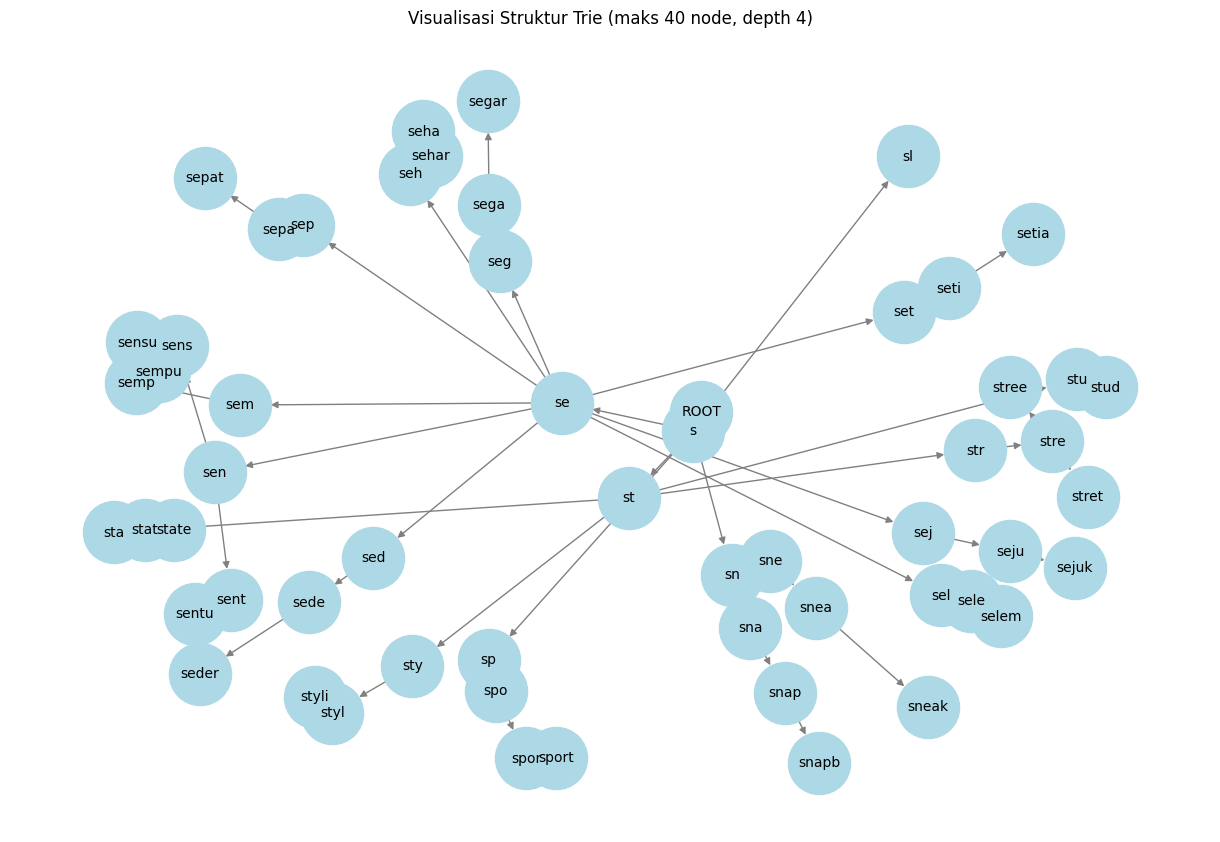

In [32]:
visualize_trie_networkx(product_trie, max_nodes=40, max_depth=4)

In [ ]:
# memvisualisasikan trie berdasarkan kata yang di cari
def visualize_trie_prefix(trie, prefix, max_nodes=30, max_depth=5):
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.DiGraph()
    node_counter = [0]

    node = trie.root
    for char in prefix.lower():
        if char not in node.children:
            print(f"Prefix '{prefix}' tidak ditemukan dalam Trie.")
            return
        node = node.children[char]

    def add_edges(node, label, depth):
        if node_counter[0] >= max_nodes or depth > max_depth:
            return
        G.add_node(label)
        node_counter[0] += 1
        for char, child in node.children.items():
            child_label = label + char
            G.add_edge(label, child_label)
            add_edges(child, child_label, depth + 1)

    add_edges(node, prefix.lower(), 0)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightgreen', font_size=10, node_size=2000, edge_color='gray')
    plt.title(f"Visualisasi Sub-Trie untuk prefix '{prefix}'")
    plt.show()


Ditemukan 53 produk dengan awalan 'se':

1. Nama Item   : Sepatu Sneakers
   Description : Sepatu Sneakers adalah pilihan yang sempurna untuk gaya kasual Anda. Didesain dengan detail modern dan kenyamanan maksimal.
   Category    : Sepatu
   Price       : 100000
   Colour      : Putih
   Shop Name   : Home Essentials

2. Nama Item   : Tas Ransel Stylish
   Description : Tas Ransel Stylish memberikan gaya dan fungsi yang sempurna. Terbuat dari bahan berkualitas dan dilengkapi dengan banyak kantong.
   Category    : Tas
   Price       : 200000
   Colour      : Merah
   Shop Name   : Sports World

3. Nama Item   : Topi Fedora Elegan
   Description : Topi Fedora Elegan memberikan sentuhan klasik yang tak lekang oleh waktu. Cocok untuk melengkapi gaya retro atau modern.
   Category    : Topi
   Price       : 50000
   Colour      : Abu-abu
   Shop Name   : Gourmet Delights

4. Nama Item   : Jam Tangan Mewah
   Description : Jam Tangan Mewah adalah aksesori yang sempurna untuk menunjukkan kea

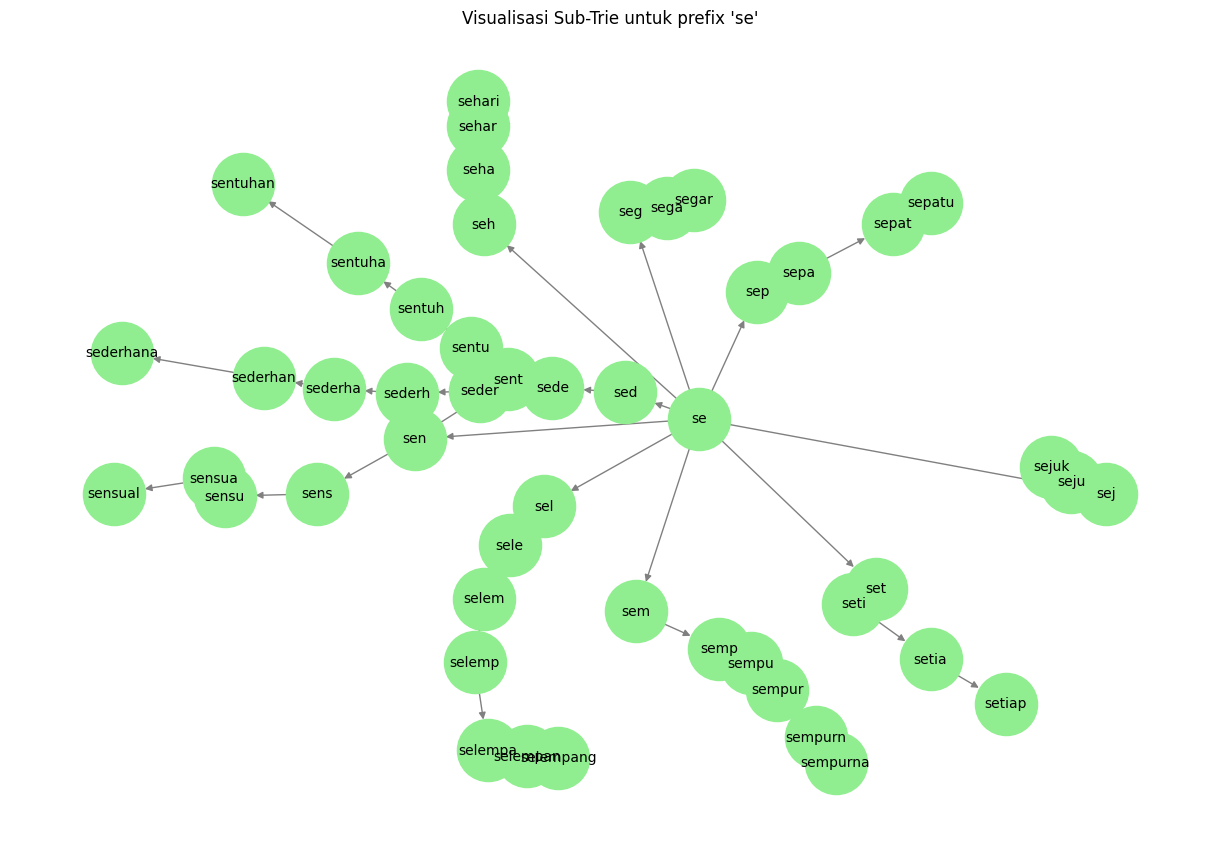

In [ ]:
# inputan pengguna untuk mencari produk apa yang di cari dan ditampilkan dan memanggil fungsi visualize_trie_prefix
prefix = input("Masukkan awalan kata pencarian: ").strip()
search_products(prefix, product_trie, df)

visualize_trie_prefix(product_trie, prefix, max_nodes=50, max_depth=6)
